In [19]:
import numpy as np
import glob 
import os
import pandas as pd


def build_lstm_sequences_with_ids_and_seasonality(input_folder, sequence_length=12, target_column="chla_mean"):
    """
    Builds LSTM sequences from per-lake CSV files with lake ID tracking and seasonal encoding.
    Filters out sequences with any NaNs.
    """
    X_all, y_all, lake_ids = [], [], []

    for file in glob.glob(os.path.join(input_folder, "Lake_*.csv")):
        df = pd.read_csv(file)
        lake_id = int(df["Lake_ID"].iloc[0])

        # Add seasonal features
        df['week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
        df['week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)


        # Define predictors (exclude metadata and target)
        predictors = df.columns.difference(["Lake_ID", "Year", "Week", "week", "week_start", "week_end", target_column])
        values = df[predictors].values
        targets = df[target_column].values

        for i in range(len(df) - sequence_length + 1):
            x_seq = values[i:i+sequence_length]
            y_val = targets[i+sequence_length - 1]

            if np.isnan(x_seq).any() or np.isnan(y_val):
                continue

            X_all.append(x_seq)
            y_all.append(y_val)
            lake_ids.append(lake_id)

    X_all = np.array(X_all)
    y_all = np.array(y_all)
    lake_ids = np.array(lake_ids)

    print(f"✅ Built {len(X_all)} sequences with shape {X_all.shape} and lake IDs (includes week_sin/cos)")
    return X_all, y_all, lake_ids





X, y, lake_ids = build_lstm_sequences_with_ids_and_seasonality("Datasets/Filtered_LSTM_Input", sequence_length=5)


✅ Built 262819 sequences with shape (262819, 5, 18) and lake IDs (includes week_sin/cos)


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import os



# Enhanced function to normalize predictors and standardize CHLA targets
def normalize_split_with_target_scaling(X, y, lake_ids, test_size=0.2, output_dir="lstm_numpy"):
    # Remap Lake_IDs to contiguous integers
    unique_ids = np.unique(lake_ids)
    id_map = {orig_id: new_id for new_id, orig_id in enumerate(unique_ids)}
    mapped_ids = np.array([id_map[i] for i in lake_ids])

    # Normalize predictors
    n_timesteps, n_features = X.shape[1], X.shape[2]
    X_flat = X.reshape(-1, n_features)
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_flat).reshape(-1, n_timesteps, n_features)

    # Standardize CHLA target
    y = y.reshape(-1, 1)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y).ravel()

    # Split all
    X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
        X_scaled, y_scaled, mapped_ids, test_size=test_size, shuffle=True, random_state=42
    )

    # Save everything
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "X_train.npy"), X_train)
    np.save(os.path.join(output_dir, "X_test.npy"), X_test)
    np.save(os.path.join(output_dir, "y_train.npy"), y_train)
    np.save(os.path.join(output_dir, "y_test.npy"), y_test)
    np.save(os.path.join(output_dir, "lake_ids_train.npy"), ids_train)
    np.save(os.path.join(output_dir, "lake_ids_test.npy"), ids_test)

    print(f"✅ Saved standardized data to: {output_dir}/")
    print(f"Train shape: {X_train.shape}, Target std: mean={y.mean():.2f}, std={y.std():.2f}")
    return X_train, X_test, y_train, y_test, ids_train, ids_test, scaler_X, scaler_y, id_map





X_train, X_test, y_train, y_test, ids_train, ids_test, scaler_X, scaler_y, id_map = normalize_split_with_target_scaling(
    X, y, lake_ids, output_dir="Datasets/LSTM"
)


✅ Saved standardized data to: Datasets/LSTM/
Train shape: (210255, 5, 18), Target std: mean=13.03, std=9.59


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Load preprocessed data
X_train = np.load("Datasets/LSTM/X_train.npy")
X_test = np.load("Datasets/LSTM/X_test.npy")
y_train = np.load("Datasets/LSTM/y_train.npy")
y_test = np.load("Datasets/LSTM/y_test.npy")
lake_ids_train = np.load("Datasets/LSTM/lake_ids_train.npy")
lake_ids_test = np.load("Datasets/LSTM/lake_ids_test.npy")

# ✅ Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
lake_ids_train_t = torch.tensor(lake_ids_train, dtype=torch.long)
lake_ids_test_t = torch.tensor(lake_ids_test, dtype=torch.long)

# ✅ DataLoader
batch_size = 64
train_loader = DataLoader(
    TensorDataset(X_train_t, lake_ids_train_t, y_train_t),
    batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False
)
test_loader = DataLoader(
    TensorDataset(X_test_t, lake_ids_test_t, y_test_t),
    batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False
)

# ✅ Model Definition


class LSTMWithLakeEmbeddingFusion(nn.Module):
    def __init__(self, input_size, num_lakes, emb_dim=16, hidden_size=64, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(num_lakes, emb_dim)

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_lstm = nn.Linear(hidden_size, 32)     # Process LSTM path
        self.fc_emb = nn.Linear(emb_dim, 16)          # Process embedding path

        self.combined = nn.Linear(32 + 16, 1)          # Combine both for final prediction

    def forward(self, x_seq, lake_id):
        lstm_out, _ = self.lstm(x_seq)                # (B, T, H)
        last_out = lstm_out[:, -1, :]                 # (B, H)

        lake_emb = self.embedding(lake_id)            # (B, emb_dim)

        lstm_feat = torch.relu(self.fc_lstm(last_out))  # (B, 32)
        lake_feat = torch.relu(self.fc_emb(lake_emb))   # (B, 16)

        combined = torch.cat([lstm_feat, lake_feat], dim=1)  # (B, 48)
        return self.combined(combined)                # (B, 1)


# ✅ Initialize model
num_lakes = int(lake_ids_train_t.max().item()) + 1
model = LSTMWithLakeEmbeddingFusion(
    input_size=X_train.shape[2],
    num_lakes=int(lake_ids_train.max().item()) + 1,
    emb_dim=16,
    hidden_size=64
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ✅ Training loop with memory safety
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for xb, lake_idb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        lake_idb = lake_idb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad()
        preds = model(xb, lake_idb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

        # 🧹 Clear GPU cache after each batch
        del xb, lake_idb, yb, preds, loss
        torch.cuda.empty_cache()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

# Save model
os.makedirs("Datasets/LSTM/trained_models", exist_ok=True)
torch.save(model.state_dict(), os.path.join("Datasets/LSTM/trained_models","lake_chla_lstm_embed.pth"))
print("✅ Model saved to: Datasets/LSTM/trained_models/lake_chla_lstm_embed.pth")








Using device: cuda
Epoch 1/20 - Loss: 0.6561
Epoch 2/20 - Loss: 0.5800
Epoch 3/20 - Loss: 0.5646
Epoch 4/20 - Loss: 0.5527
Epoch 5/20 - Loss: 0.5431
Epoch 6/20 - Loss: 0.5356
Epoch 7/20 - Loss: 0.5296
Epoch 8/20 - Loss: 0.5242
Epoch 9/20 - Loss: 0.5193
Epoch 10/20 - Loss: 0.5149
Epoch 11/20 - Loss: 0.5104
Epoch 12/20 - Loss: 0.5073
Epoch 13/20 - Loss: 0.5039
Epoch 14/20 - Loss: 0.5002
Epoch 15/20 - Loss: 0.4977
Epoch 16/20 - Loss: 0.4939
Epoch 17/20 - Loss: 0.4919
Epoch 18/20 - Loss: 0.4895
Epoch 19/20 - Loss: 0.4864
Epoch 20/20 - Loss: 0.4839
✅ Model saved to: lake_chla_lstm_embed.pth


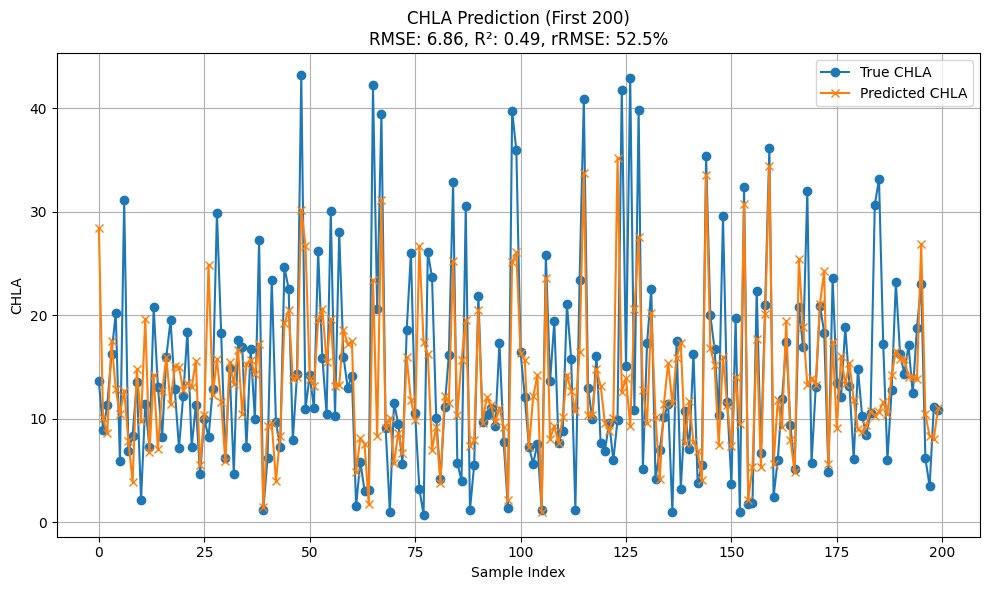

In [24]:
def evaluate_lstm_with_inverse_scaling(model, test_loader, device, scaler_y, max_batches=None):
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, r2_score

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for i, (xb, lake_idb, yb) in enumerate(test_loader):
            xb, lake_idb, yb = xb.to(device), lake_idb.to(device), yb.to(device)
            preds = model(xb, lake_idb)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
            if max_batches is not None and i >= max_batches:
                break

    preds_scaled = np.concatenate(all_preds)
    targets_scaled = np.concatenate(all_targets)

    # Inverse transform to original CHLA scale
    preds_original = scaler_y.inverse_transform(preds_scaled)
    targets_original = scaler_y.inverse_transform(targets_scaled)


    # Metrics
    rmse = np.sqrt(mean_squared_error(targets_original, preds_original))
    r2 = r2_score(targets_original, preds_original)
    mean_true = targets_original.mean()
    rrmse = (rmse / mean_true) * 100
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(targets_original[:200], label='True CHLA', marker='o')
    plt.plot(preds_original[:200], label='Predicted CHLA', marker='x')
    plt.title(f"CHLA Prediction (First 200)\nRMSE: {rmse:.2f}, R²: {r2:.2f}, rRMSE: {rrmse:.1f}%")
    plt.xlabel("Sample Index")
    plt.ylabel("CHLA")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return rmse, r2

rmse, r2 = evaluate_lstm_with_inverse_scaling(model, test_loader, device, scaler_y)


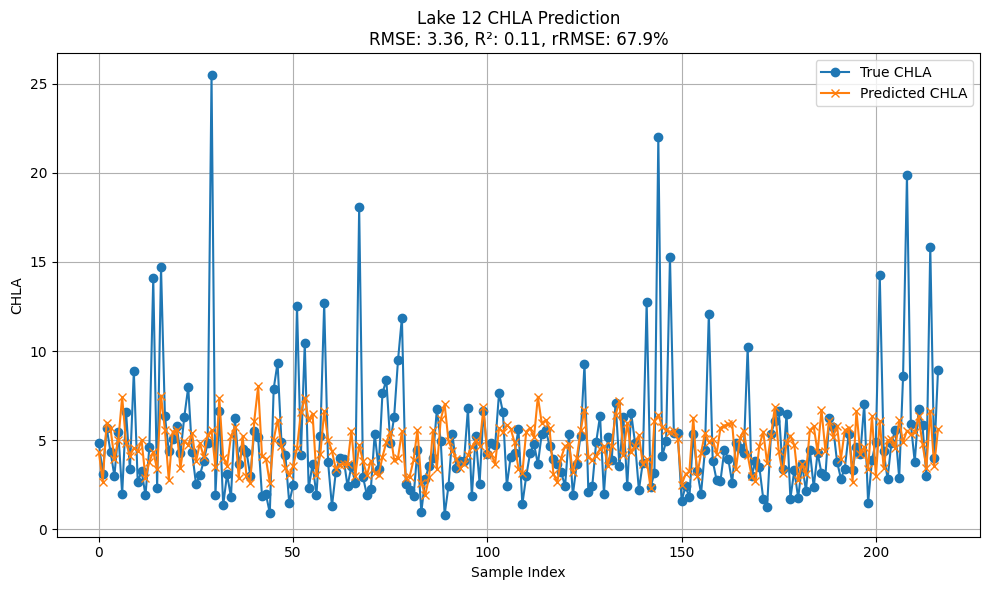

In [32]:
def plot_lake_predictions_with_rrmse(lake_original_id, model, X_test, y_test, lake_ids_test, id_map, scaler_y, device):
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, r2_score

    model.eval()

    # Map original lake ID to remapped index
    lake_index = id_map.get(lake_original_id)
    if lake_index is None:
        print(f"Lake ID {lake_original_id} not found in id_map.")
        return

    # Select samples for this lake
    indices = np.where(lake_ids_test == lake_index)[0]
    if len(indices) == 0:
        print(f"No test samples found for Lake ID {lake_original_id}.")
        return

    X_lake = torch.tensor(X_test[indices], dtype=torch.float32).to(device)
    lake_ids_tensor = torch.tensor([lake_index] * len(indices), dtype=torch.long).to(device)
    y_true_scaled = y_test[indices]

    with torch.no_grad():
        y_pred_scaled = model(X_lake, lake_ids_tensor).cpu().numpy()

    # Inverse transform CHLA
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_true = scaler_y.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()


    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mean_true = y_true.mean()
    rrmse = (rmse / mean_true) * 100

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label="True CHLA", marker='o')
    plt.plot(y_pred, label="Predicted CHLA", marker='x')
    plt.title(f"Lake {lake_original_id} CHLA Prediction\nRMSE: {rmse:.2f}, R²: {r2:.2f}, rRMSE: {rrmse:.1f}%")
    plt.xlabel("Sample Index")
    plt.ylabel("CHLA")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return rmse, r2, rrmse

rmse, r2, rrmse = plot_lake_predictions_with_rrmse(
    12, model, X_test, y_test, lake_ids_test, id_map, scaler_y, device
)


